In [8]:
import torch
print(torch.__version__)         
print(torch.cuda.is_available())  
print(torch.version.cuda)         
print(torch.cuda.current_device()) 
print(torch.cuda.get_device_name(0)) 

2.5.1+cu124
True
12.4
0
Tesla T4


In [ ]:
#!pip install torch torchvision numpy pillow
#!pip install git+https://github.com/yourusername/stylegan2-ada-pytorch.git

In [10]:
import os
os.environ["TORCH_CUDA_ARCH_LIST"] = "7.5"  # Tesla T4 (compute capability 7.5)

new


In [21]:
import torch
import tensorflow as tf
import numpy as np
import gc
from PIL import Image
import os
import sys
sys.path.append('/kaggle/input/stylegan2/stylegan2-ada-pytorch-main/stylegan2-ada-pytorch-main')
stylegan_model_path = '/kaggle/input/ffhq-pkl/ffhq.pkl'
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0, InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Concatenate, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.mixed_precision import set_global_policy
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.linalg import sqrtm
import dnnlib
import legacy
import tensorflow.data as tf_data

In [22]:
# Enable mixed precision
set_global_policy('mixed_float16')

In [23]:
# Disable CUDA graph to reduce memory usage
os.environ['XLA_FLAGS'] = '--xla_gpu_enable_command_buffer='

In [24]:
# NEW: Configure memory growth once at the start
def configure_gpu_memory():
    try:
        physical_devices = tf.config.list_physical_devices('GPU')
        if physical_devices:
            for gpu in physical_devices:
                tf.config.experimental.set_memory_growth(gpu, True)
            print(f"Configured memory growth for {len(physical_devices)} GPU(s)")
        else:
            print("No GPU devices found")
    except Exception as e:
        print(f"Error configuring memory growth: {e}")

# Call memory configuration before any GPU operations
configure_gpu_memory()

# Enhanced memory cleanup
def clear_gpu_memory():
    tf.keras.backend.clear_session()
    gc.collect()
    torch.cuda.empty_cache()
    try:
        tf.config.experimental.reset_memory_stats('GPU:0')
    except Exception as e:
        print(f"Error resetting memory stats: {e}")

Configured memory growth for 2 GPU(s)


In [25]:
# Paths and device setup (unchanged)
STYLEGAN_MODEL_PATH = '/kaggle/input/ffhq-pkl/ffhq.pkl'
EXTRA_REAL_IMAGE_DIR = '/kaggle/input/80k-real-and-fake-images/80k Real and Fake Images/real_vs_fake/real-vs-fake/train/real'
REAL_IMAGE_DIR = '/kaggle/input/80k-real-and-fake-images/80k Real and Fake Images/real_vs_fake/real-vs-fake/test/real'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [26]:
# Load StyleGAN2 Generator (unchanged)
def load_stylegan_generator(path):
    with dnnlib.util.open_url(path) as f:
        G = legacy.load_network_pkl(f)['G_ema'].to(device).eval()
    return G

In [27]:
# Image loading and generation functions (unchanged)
def create_dataset(paths, labels, batch_size=16, image_size=(224, 224)):
    dataset = tf_data.Dataset.from_tensor_slices((paths, labels))
    def load_and_preprocess(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.resize(img, image_size)
        img = preprocess_input(img)
        return img, label
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size).prefetch(tf_data.AUTOTUNE)

In [28]:
def load_images_from_paths(paths, image_size=(224, 224)):
    images = []
    for path in paths:
        img = Image.open(path).convert('RGB').resize(image_size)
        images.append(np.array(img))
    return np.array(images).astype('float32')

In [29]:
def generate_images(generator, batch_size=16, latent_dim=512, image_size=224, output_dir="/kaggle/working/output", step=0):
    os.makedirs(output_dir, exist_ok=True)
    z = torch.randn(batch_size, latent_dim).cuda()
    c = torch.zeros([batch_size, generator.c_dim]).cuda()
    images = generator(z, c)
    images_resized = torch.nn.functional.interpolate(
        images, size=(image_size, image_size), mode='bilinear', align_corners=False
    )
    images_resized = images_resized.permute(0, 2, 3, 1)
    images_resized = (images_resized * 127.5 + 127.5).clamp(0, 255)
    images_resized = images_resized.cpu().numpy().astype(np.uint8)
    img_paths = []
    for i, img_arr in enumerate(images_resized):
        img = Image.fromarray(img_arr)
        path = os.path.join(output_dir, f"fake_{step}_{i}.png")
        img.save(path)
        img_paths.append(path)
    return img_paths

In [30]:
def generate_many_images(generator, total=512, batch_size=16, output_dir="/kaggle/working/output"):
    paths = []
    for i in range(total // batch_size):
        batch_paths = generate_images(generator, batch_size=batch_size, output_dir=output_dir, step=i)
        paths.extend(batch_paths)
    return paths

In [31]:
def load_real_images(directory, num_images=512, image_size=224):
    image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')
    paths = [
        os.path.join(directory, f)
        for f in os.listdir(directory)
        if f.lower().endswith(image_extensions)
    ]
    paths = paths[:num_images]
    images = []
    for p in paths:
        try:
            img = Image.open(p).convert('RGB').resize((image_size, image_size))
            images.append(np.array(img))
        except IsADirectoryError:
            print(f"Skipped directory: {p}")
            continue
    return np.array(images).astype('float32')

In [32]:
# Hybrid discriminator (unchanged)
def build_hybrid_discriminator(input_shape=(224, 224, 3)):
    input1 = Input(shape=input_shape, name='input_resnet')
    input2 = Input(shape=input_shape, name='input_densenet')
    input3 = Input(shape=input_shape, name='input_efficientnet')
    base1 = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    base2 = DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape)
    base3 = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)
    for base in [base1, base2, base3]:
        base.trainable = True
        for layer in base.layers[:-10]:
            layer.trainable = False
    out1 = base1(input1)
    out2 = base2(input2)
    out3 = base3(input3)
    out1 = GlobalAveragePooling2D(name='gap_resnet')(out1)
    out2 = GlobalAveragePooling2D(name='gap_densenet')(out2)
    out3 = GlobalAveragePooling2D(name='gap_efficientnet')(out3)
    concat = Concatenate(name='concatenate_features')([out1, out2, out3])
    x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01))(concat)
    x = BatchNormalization(name='batch_norm')(x)
    x = Dropout(0.6)(x)
    output = Dense(1, activation='sigmoid', dtype='float32')(x)
    model = Model(inputs=[input1, input2, input3], outputs=output, name='hybrid_discriminator')
    return model

In [33]:
# FID calculation (unchanged)
def calculate_fid(act1, act2):
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2)
    covmean = sqrtm(sigma1.dot(sigma2) + np.eye(sigma1.shape[0]) * 1e-6)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return max(fid, 0)

In [34]:
# Updated evaluate_discriminator (deferred InceptionV3 initialization)
def evaluate_discriminator(model, real_imgs, fake_imgs, batch_size=16):
    real_imgs = real_imgs.astype('float32')
    fake_imgs = fake_imgs.astype('float32')
    X = np.concatenate([real_imgs, fake_imgs], axis=0)
    y_true = np.concatenate([np.ones(len(real_imgs)), np.zeros(len(fake_imgs))])
    
    # Process predictions in smaller batches
    y_pred = []
    num_batches = (len(X) + batch_size - 1) // batch_size
    for i in tqdm(range(num_batches), desc="Predicting"):
        start = i * batch_size
        end = min((i + 1) * batch_size, len(X))
        batch_X = X[start:end]
        batch_X_preprocessed = preprocess_input(batch_X)
        batch_pred = model.predict(
            [batch_X_preprocessed, batch_X_preprocessed, batch_X_preprocessed],
            batch_size=batch_size,
            verbose=0
        ).flatten()
        y_pred.append(batch_pred)
        tf.keras.backend.clear_session()
        gc.collect()
    
    y_pred = np.concatenate(y_pred)
    y_pred_bin = (y_pred > 0.5).astype(int)
    
    print(classification_report(y_true, y_pred_bin, target_names=["Fake", "Real"]))
    
    cm = confusion_matrix(y_true, y_pred_bin)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.title('Confusion Matrix')
    plt.show()
    
    # Initialize InceptionV3 here to avoid early memory allocation
    fid_model = InceptionV3(include_top=False, pooling='avg', input_shape=(224, 224, 3))
    
    # FID calculation in batches
    act_real = []
    act_fake = []
    for i in tqdm(range(num_batches), desc="FID Calculation"):
        start = i * batch_size
        end = min((i + 1) * batch_size, len(real_imgs))
        if end > start:
            batch_real = preprocess_input(real_imgs[start:end])
            batch_fake = preprocess_input(fake_imgs[start:end]) if start < len(fake_imgs) else None
            act_real.append(fid_model.predict(batch_real, batch_size=batch_size, verbose=0))
            if batch_fake is not None:
                act_fake.append(fid_model.predict(batch_fake, batch_size=batch_size, verbose=0))
    
    act_real = np.concatenate(act_real)
    act_fake = np.concatenate(act_fake[:len(fake_imgs) // batch_size])
    fid = calculate_fid(act_real, act_fake)
    print(f"FID: {fid:.2f}")
    
    # Clear FID model memory
    del fid_model
    clear_gpu_memory()

In [35]:
# Display images and results (unchanged)
def display_images_and_results(model, real_imgs, fake_imgs, num_images=20):
    num_each = num_images // 2
    indices = np.random.choice(len(real_imgs), num_each, replace=False)
    selected_real = real_imgs[indices]
    selected_fake = fake_imgs[indices]
    images = np.concatenate([selected_real, selected_fake])
    true_labels = np.concatenate([np.ones(num_each), np.zeros(num_each)])
    images_preprocessed = preprocess_input(images.copy())
    pred_probs = model.predict([images_preprocessed]*3, batch_size=16).flatten()
    pred_labels = (pred_probs > 0.5).astype(int)
    rows, cols = 4, 5
    fig, axes = plt.subplots(rows, cols, figsize=(20, 16))
    axes = axes.flatten()
    for i in range(num_images):
        img = images[i].astype(np.uint8)
        true_label = "Real" if true_labels[i] == 1 else "Fake"
        pred_label = "Real" if pred_labels[i] == 1 else "Fake"
        correct = "✓" if true_label == pred_label else "✗"
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Orig: {true_label} | Pred: {pred_label} {correct}", fontsize=12)
    plt.tight_layout()
    plt.show()

In [36]:
# Generator training (unchanged)
def train_generator(G, discriminator, batch_size=16, latent_dim=512):
    z = torch.randn(batch_size, latent_dim).cuda()
    c = torch.zeros([batch_size, G.c_dim]).cuda()
    fake_imgs = G(z, c)
    fake_imgs_resized = torch.nn.functional.interpolate(fake_imgs, size=(224, 224), mode='bilinear')
    fake_imgs_tf = tf.convert_to_tensor(fake_imgs_resized.permute(0, 2, 3, 1).cpu().numpy() * 127.5 + 127.5)
    fake_preds = discriminator([fake_imgs_tf, fake_imgs_tf, fake_imgs_tf])
    g_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(fake_preds), fake_preds))
    return g_loss

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.4731 - loss: 389.7730 - val_accuracy: 0.1359 - val_loss: 356.7891 - learning_rate: 1.0000e-04
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step - accuracy: 0.7537 - loss: 345.6516 - val_accuracy: 0.5534 - val_loss: 314.6975 - learning_rate: 1.0000e-04
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.7914 - loss: 304.4572 - val_accuracy: 0.6796 - val_loss: 275.0726 - learning_rate: 1.0000e-04
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - accuracy: 0.9400 - loss: 265.2598 - val_accuracy: 0.8058 - val_loss: 237.7140 - learning_rate: 1.0000e-04
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.9035 - loss: 228.6590 - val_accuracy: 0.8447 - val_loss: 202.9667 - learning_rate: 1.0000e-04
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - accuracy: 0.9612 - loss: 194.5524 - val_accuracy: 0.8641 - val_loss: 170.9606 - learning_rate: 1.0000e-04
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 

Predicting: 100%|██████████| 32/32 [02:58<00:00,  5.59s/it]

              precision    recall  f1-score   support

        Fake       0.63      1.00      0.77       256
        Real       1.00      0.41      0.58       256

    accuracy                           0.71       512
   macro avg       0.81      0.71      0.68       512
weighted avg       0.81      0.71      0.68       512



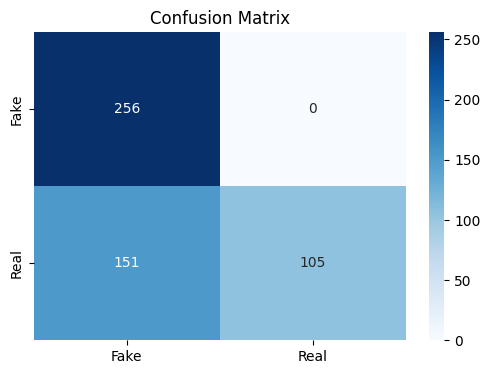

FID Calculation: 100%|██████████| 32/32 [00:10<00:00,  3.18it/s]


FID: 24533.54

--- Displaying Images and Detection Results for Epoch 1 ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 26s 24s/step


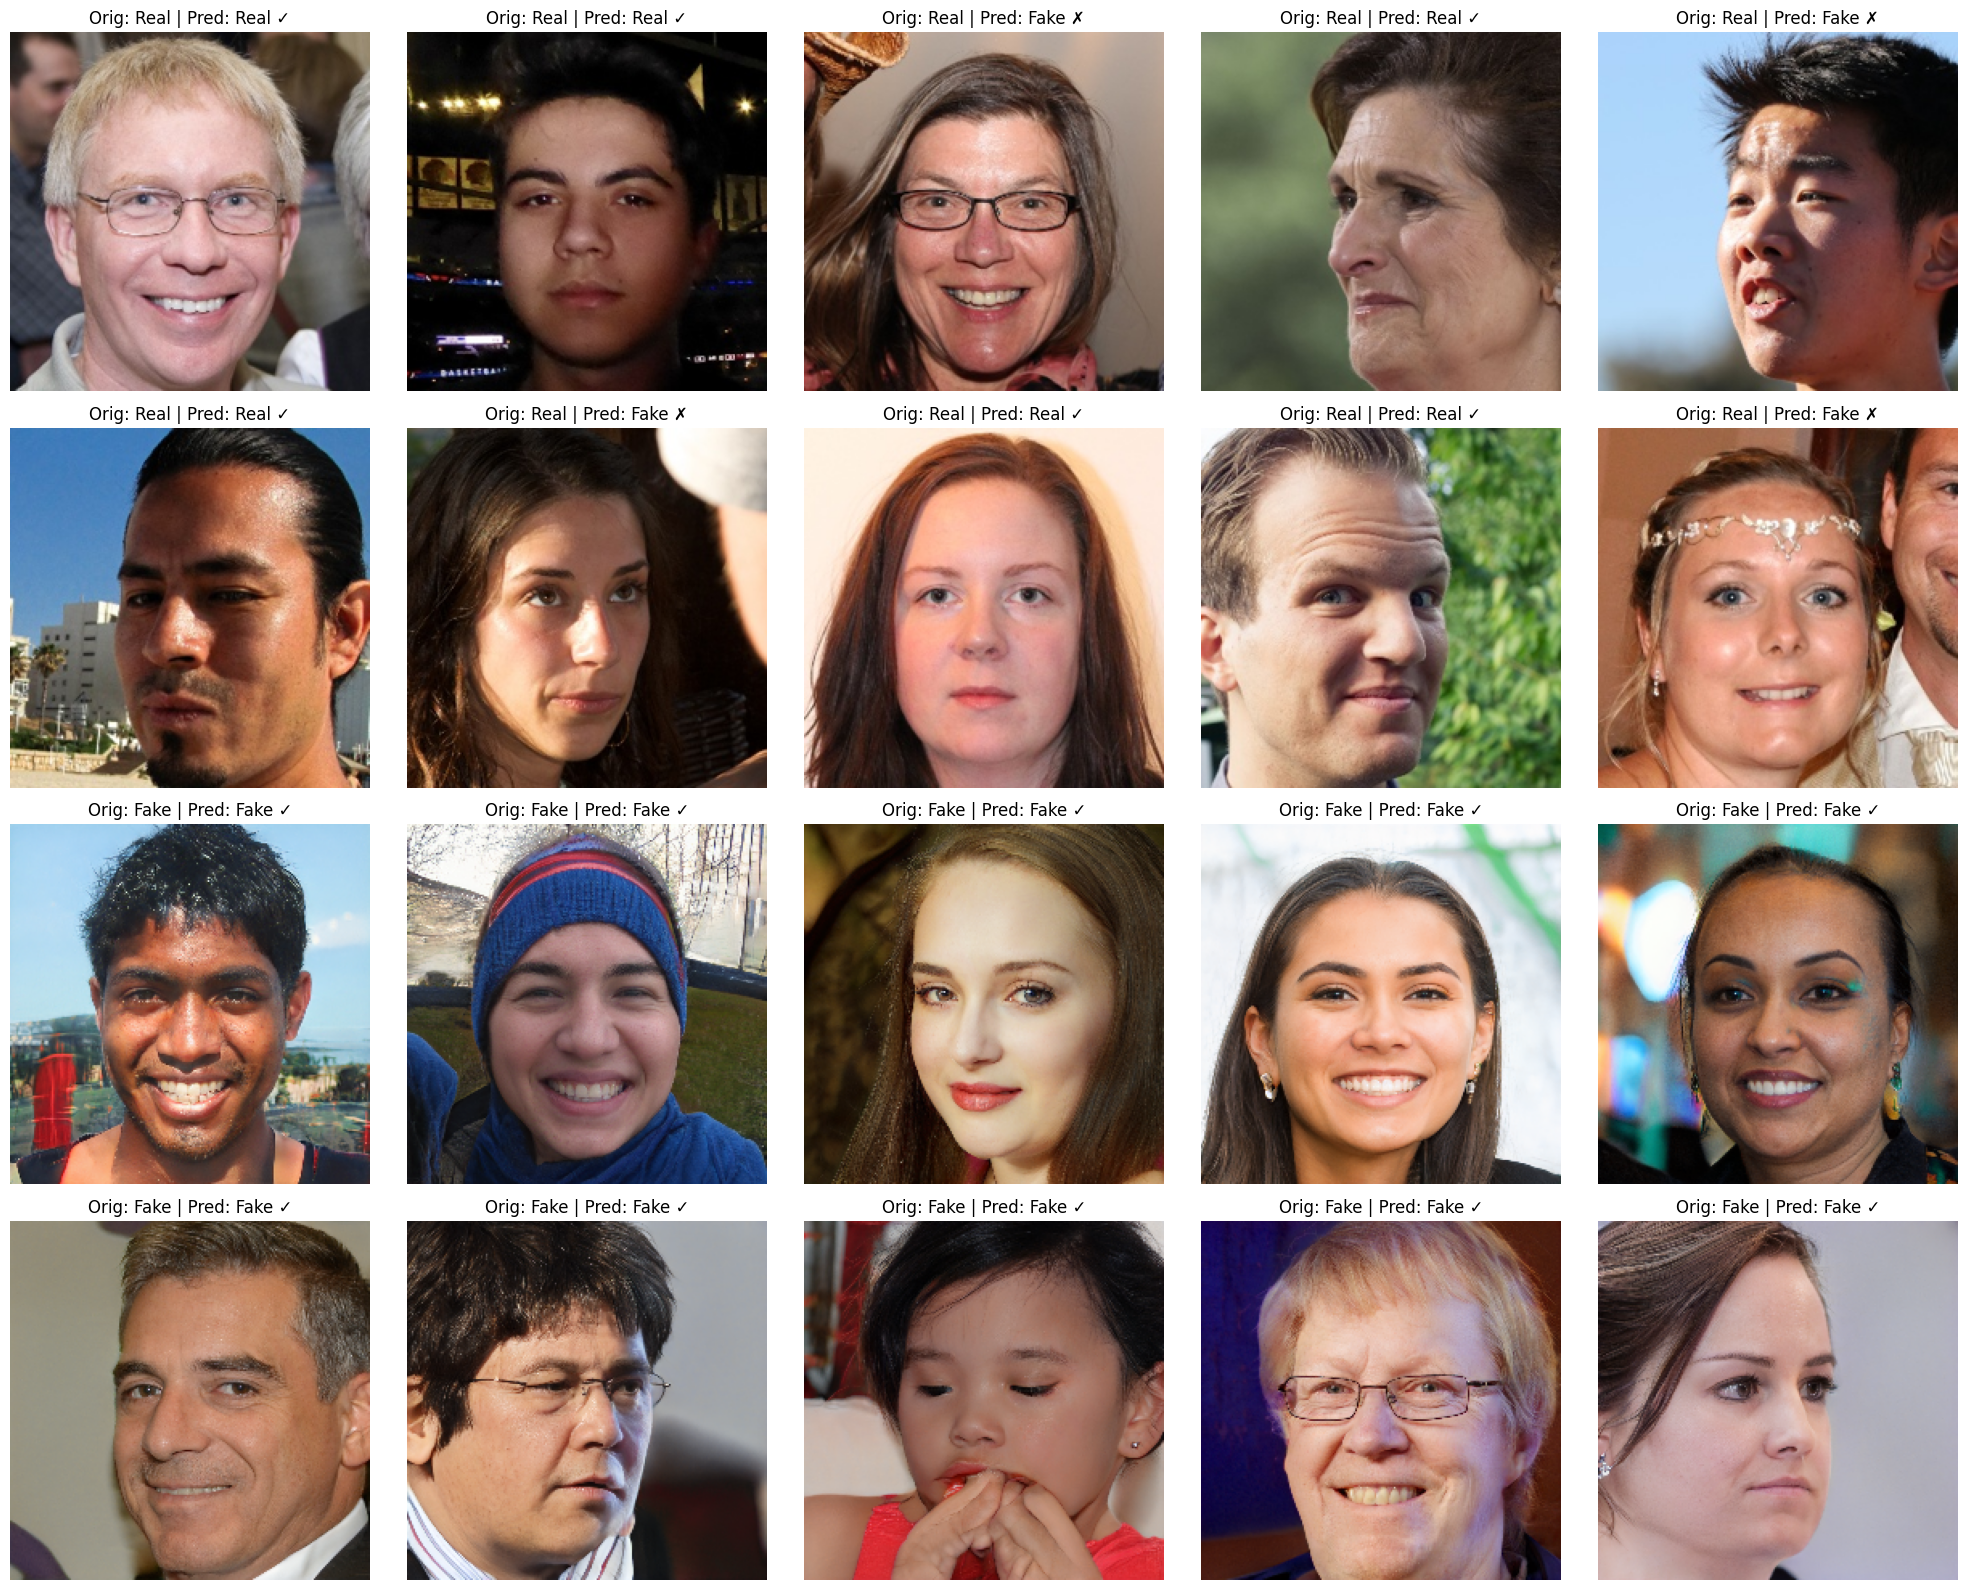

In [37]:
# Data augmentation (unchanged)
datagen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    zoom_range=[0.8, 1.2],
    shear_range=0.2,
    channel_shift_range=20
)

# Load images and generator
G = load_stylegan_generator(STYLEGAN_MODEL_PATH)
all_fake_paths = generate_many_images(G, total=512, batch_size=16)
all_fake_imgs = load_images_from_paths(all_fake_paths)
all_real_imgs = load_real_images(REAL_IMAGE_DIR, num_images=512)
extra_real_imgs = load_real_images(EXTRA_REAL_IMAGE_DIR, num_images=512)

# Generator optimizer
g_optimizer = torch.optim.Adam(G.parameters(), lr=1e-4, betas=(0.5, 0.999))

# Training callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Training loop
for epoch in range(1):
    clear_gpu_memory()
    real_indices = np.random.permutation(len(all_real_imgs))
    fake_indices = np.random.permutation(len(all_fake_imgs))
    shuffled_real_imgs = all_real_imgs[real_indices]
    shuffled_fake_imgs = all_fake_imgs[fake_indices]
    X = np.concatenate([shuffled_real_imgs[:256], shuffled_fake_imgs[:256]])
    y = np.concatenate([np.ones(256), np.zeros(256)])
    X_aug = next(datagen.flow(X, batch_size=512, shuffle=False))
    X_preprocessed = preprocess_input(X_aug)
    
    hybrid_discriminator = build_hybrid_discriminator(input_shape=(224, 224, 3))
    hybrid_discriminator.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    hybrid_discriminator.fit(
        [X_preprocessed, X_preprocessed, X_preprocessed], y,
        epochs=50,
        batch_size=16,
        validation_split=0.2,
        callbacks=[early_stopping, lr_scheduler]
    )
    
    g_loss = train_generator(G, hybrid_discriminator)
    print(f"Generator Loss: {g_loss:.4f}")
    
    eval_real_imgs = shuffled_real_imgs[:128]
    eval_fake_imgs = shuffled_fake_imgs[:128]
    print(f"\n--- Evaluation for Epoch {epoch + 1} ---")
    fid_real_imgs = shuffled_real_imgs[:256]
    fid_fake_imgs = shuffled_fake_imgs[:256]
    evaluate_discriminator(hybrid_discriminator, fid_real_imgs, fid_fake_imgs, batch_size=16)
    
    print(f"\n--- Displaying Images and Detection Results for Epoch {epoch + 1} ---")
    display_images_and_results(hybrid_discriminator, eval_real_imgs[:10], eval_fake_imgs[:10], num_images=20)
    
    clear_gpu_memory()